In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.metrics import as_cumulative_dynamic_auc_scorer
from sklearn.model_selection import cross_val_score
from sksurv.metrics import cumulative_dynamic_auc
from sklearn.model_selection import KFold
import pickle


In [166]:
# # Specify the path to your pickle file
# file_path = "../../../dataset/cri_compustat_merged_v8.pkl"

# # Open the pickle file for reading
# with open(file_path, 'rb') as file:
#     # Load the data from the pickle file
#     df = pickle.load(file)

# df.head()

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,day_sales_outstanding,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio
0,42404,2000.0,1,0.089239,0.011089,0.677551,0.332808,1.411466,0.027249,-0.148249,...,197946.597222,0.000000,-5.000000,-0.0,1.0,-5.251700e+06,-2.189250e+07,-2.185540e+07,-149041.103448,-297211.000000
1,37610,2000.0,1,0.089239,0.011089,0.087376,-0.524732,0.906364,-0.071829,0.000292,...,190.722132,2.177571,-1.220833,0.0,1.0,2.498284e+01,-7.402171e+01,-6.856532e+01,-0.904380,1.490291
2,49536,2000.0,1,0.313050,0.007314,3.693176,0.625516,1.872712,1.010148,-0.069998,...,0.000000,0.036899,-78.333333,-0.0,1.0,7.542644e+01,-2.309701e+02,-1.503731e+02,-11.081841,-430.222222
3,32417,2000.0,1,0.089239,0.011089,6.165654,0.863910,1.275166,0.184606,0.013360,...,269.176235,0.551135,66.510333,0.0,1.0,5.234158e+01,-2.327468e+01,-1.952816e+01,-395.933333,777.750000
4,44933,2000.0,1,0.089239,0.011089,0.629410,-0.874122,0.000000,0.000000,0.004436,...,0.000000,-2.766467,19.196429,0.0,1.0,7.495250e+01,3.133312e+01,4.316023e+01,0.020216,2.013002


In [3]:
from google.oauth2 import service_account
import pandas_gbq as gbq 
import json
from pandas_gbq import to_gbq, read_gbq

credentials_path = '../../../token.json'

# Authenticate with your credentials
credentials = service_account.Credentials.from_service_account_file(
    credentials_path, scopes=['https://www.googleapis.com/auth/bigquery'])

# Set the credentials for pandas_gbq
gbq.context.credentials = credentials

In [4]:
# import dataframe from GBQ

df = read_gbq(f"""

SELECT *
FROM capstone-402105.capstone.cri_compustat_data

""",project_id='capstone-402105', dialect='standard')

Downloading: 100%|██████████|


In [5]:
# df['Duration'] = df['Duration'].dt.total_seconds() / (24 * 60 * 60)
df['Default_12'] = df['Default_12'].map(lambda x : False if x == 0.0 else True)

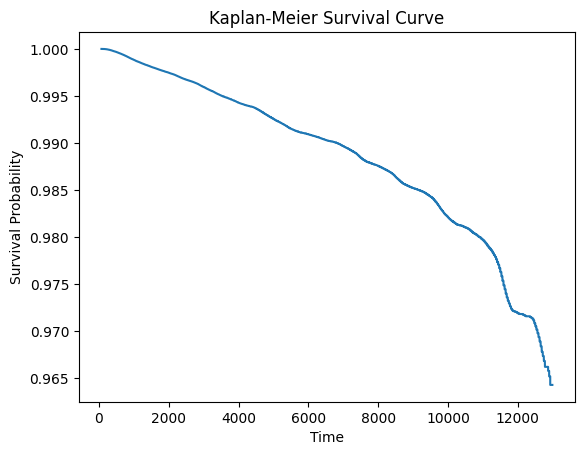

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

# Extract the time and status (event) data
time, status = np.array(df['Duration'], dtype=float), np.array(df['Default_12'], dtype=bool)

# Estimate the Kaplan-Meier survival curve
time, survival_prob = kaplan_meier_estimator(status, time)

# Plot the Kaplan-Meier survival curve
plt.step(time, survival_prob, where="post")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Kaplan-Meier Survival Curve")
plt.show()

In [8]:
from datetime import datetime
import pytz

date2022 = datetime(2022, 1, 1).replace(tzinfo=pytz.UTC)
train_df = df[df["EventDate"] < date2022]
test_df = df[df["EventDate"] >= date2022]
print("train_df shape:", train_df.shape)
print("test_df shape:", test_df.shape)

train_df shape: (1142877, 56)
test_df shape: (36537, 56)


In [9]:
selected_features = ['StkIndx', 'STInt', 'dtdlevel', 'dtdtrend',
        'liqnonfinlevel', 'liqnonfintrend', 'ni2talevel', 'ni2tatrend',
        'sizelevel', 'sizetrend', 'm2b', 'sigma', 'liqfinlevel', 'lqfintrend',
        'DTDmedianFin', 'DTDmedianNonFin', 'dummy297fin', 
        'current_ratio', 'quick_ratio', 'cash_ratio', 'net_working_capital',
        'debt_ratio', 'debt_to_equity_ratio', 'equity_ratio',
        'cashflow_to_debt_ratio', 'net_profit_margin', 'return_on_assets',
        'asset_turnover', 'inventory_turnover', 'days_in_inventory',
        'receivables_turnover', 'day_sales_outstanding',
        'working_capital_turnover', 'price_to_earnings',
        'dividend_payout_ratio', 'retention_ratio', 'gross_margin_ratio',
        'operating_profit_margin', 'ebitda_margin',
        'debt_service_coverage_ratio', 'interest_coverage_ratio']

In [10]:
X_train = train_df[selected_features]
y_train_df = train_df[['Default_12', 'Duration']]

In [11]:
print(y_train_df.head())

   Default_12  Duration
0       False     11105
1       False      8114
2       False      3823
3       False     11105
4       False     11105


In [12]:
y_train = np.array(y_train_df.to_records(index=False))
print(y_train)

[(False, 11105) (False, 8114) (False, 3823) ... (False, 4896)
 (False, 2162) (False, 1114)]


In [13]:
model = CoxPHSurvivalAnalysis()
model.fit(X_train, y_train)

c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\linear_model\coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=3.02862e-19): result may not be accurate.
  delta = solve(
c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\linear_model\coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=6.83206e-22): result may not be accurate.
  delta = solve(
c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\linear_model\coxph.py:173: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])
c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\linear_model\coxph.py:170: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sksurv\linear_model\coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=2.27852e-20): result may not be accurate.
  delta = solve

CoxPHSurvivalAnalysis()

In [14]:
X_test = test_df[selected_features]
y_test_df = test_df[['Default_12', 'Duration']]
y_test = np.array(y_test_df.to_records(index=False))

In [29]:
prediction = model.predict(X_test)
result = concordance_index_censored(y_test['Default_12'], y_test['Duration'], prediction)
print(f"Concordance Index (C-index): {result[0]:.4f}")

Concordance Index (C-index): 0.5000
